In [20]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

## Target distribution: trimodal normal distribution (1D)

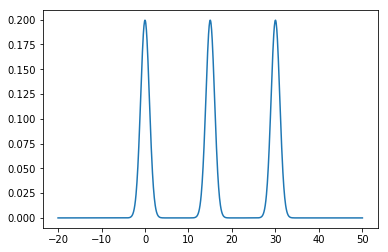

In [21]:
def mixtureTarget(x):
    return 0.5 * (stats.norm.pdf(x,loc=0,scale=1) + stats.norm.pdf(x,loc=15,scale=1) + stats.norm.pdf(x,loc=30,scale=1))

x = np.linspace(-20,50,1000)
plt.plot(x,mixtureTarget(x))
plt.show()

## Tempered (aka heated) distribution at a range of temperatures

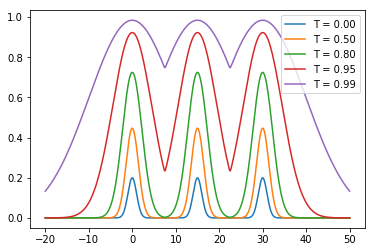

In [22]:
def temperedDistribution(x,beta):
    return (mixtureTarget(x) ** (1 - beta))
x = np.linspace(-20,50,1000)
plt.plot(x,temperedDistribution(x,0.0),label='T = 0.00')
plt.plot(x,temperedDistribution(x,0.5),label='T = 0.50')
plt.plot(x,temperedDistribution(x,0.8),label='T = 0.80')
plt.plot(x,temperedDistribution(x,0.95),label='T = 0.95')
plt.plot(x,temperedDistribution(x,0.99),label='T = 0.99')
plt.legend()
plt.show()

## Implementing Del Moral (2006) algorithm 3.1.1 using expression (31) for w tilde

In [23]:
def initialStep(numParticles):
    lSamples = np.random.normal(loc=4,scale=10,size=numParticles)
    lWeights = np.zeros(numParticles)
    for i in range(0, numParticles):
        lWeights[i] = temperedDistribution(lSamples[i],1) / stats.norm.pdf(lSamples[i],loc=4,scale=10)
    lWeights = lWeights / np.sum(lWeights)
    return lSamples, lWeights
def kernelSample(lSamples,beta,aSigma):
    numParticles = len(lSamples)
    lProposed = np.zeros(numParticles)
    for i in range(0, numParticles):
        lProposed[i] = np.random.normal(loc=lSamples[i],scale=aSigma,size=1)[0]
    lNewSamples = np.zeros(numParticles)
    for i in range(0, numParticles):
        if (temperedDistribution(lProposed[i],beta) / temperedDistribution(lSamples[i],beta)) <= np.random.uniform(size=1):
            lNewSamples[i] = lSamples[i]
        else:
            lNewSamples[i] = lProposed[i]
    return lNewSamples
def newWeights(lWOld,lSamplesOld,lSamplesNew,betaOld,betaNew,aSigma):
    numParticles = len(lWOld)
    lNewW = np.zeros(numParticles)
    for i in range(0, numParticles):
        lNewW[i] = newWeight(lWOld[i], lSamplesOld[i], lSamplesNew[i], betaOld, betaNew, aSigma)
    return lNewW / np.sum(lNewW)
def resample(lWeights,lSamples):
    numSamples = len(lWeights)
    lSelected = np.random.multinomial(numSamples,lWeights)
    lNewSample = np.zeros(0)
    for i in range(0,numSamples):
        if lSelected[i] > 0:
            lNewSample = np.concatenate((lNewSample,np.repeat(lSamples[i],lSelected[i])))
    return lNewSample, np.repeat(1.0/numSamples,numSamples)
def wTilde(xOld,xNew,betaOld,betaNew,aSigma):
    numerator = temperedDistribution(xOld,betaNew) 
    denominator = temperedDistribution(xOld,betaOld) 
    return numerator / denominator
def newWeight(WOld,xOld,xNew,betaOld,betaNew,aSigma):
    wtilde = wTilde(xOld,xNew,betaOld,betaNew,aSigma)
    return WOld * wtilde
def ESS(lWeights):
    return 1.0 / np.sum(lWeights**2)
def steps2And3(lSamplesOld,lWeightsOld,betaOld,betaNew,aSigma,ThresholdESS):
    if ESS(lWeightsOld) < ThresholdESS:
        lResamples, lWOld = resample(lWeightsOld,lSamplesOld)
    else:
        lResamples, lWOld = lSamplesOld, lWeightsOld
    lSamplesNew = kernelSample(lResamples,betaNew,aSigma)
    lNewW = newWeights(lWOld,lSamplesOld,lSamplesNew,betaOld,betaNew,aSigma)
    lSamplesNew, lNewW = resample(lNewW,lSamplesNew)
    return lSamplesNew, lNewW
def iterate(lBetaSchedule,lSamplesFromStep1,lWeightsFromStep1,aSigma,ThresholdESS):
    numIterates = len(lBetaSchedule)
    numParticles = len(lSamplesFromStep1)
    mSamples = np.zeros((numParticles,numIterates))
    mSamples[:,0] = lSamplesFromStep1
    lWeightsOld = lWeightsFromStep1
    for i in range(0,numIterates-1):
        lNewSamples,lWeightsNew = steps2And3(mSamples[:,i],lWeightsOld,lBetaSchedule[i],lBetaSchedule[i+1],aSigma,ThresholdESS)
        lWeightsOld = lWeightsNew
        mSamples[:,i+1] = lNewSamples
    return mSamples[:,-1]

## Running SMC using a temperature schedule from T = 0.01 to T = 1 (the actual distribution that we are sampling form) with 4000 particles, a step size (for the MCMC kernels) of 1, and a threshold ESS of 2000

In [24]:
lSamples, lWeights = initialStep(4000)
lBeta = np.linspace(0.0,0.99,10)[::-1]
lData = iterate(lBeta,lSamples,lWeights,1, 2000)

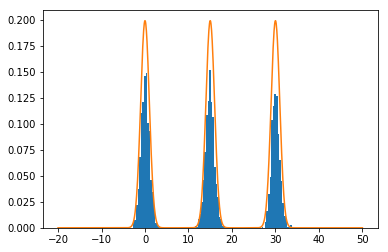

In [25]:
x = np.linspace(-20,50,1000)
plt.hist(lData, 100, density=True)
plt.plot(x,mixtureTarget(x))
plt.show()